# Update map statistics

We need summaries of areas of each Ecosystem functional group over specific areas (countries, large marine areas, ex

## Calculate area statistics for one layer
This is one way to calculate area statistics using python

### Import modules

In [130]:
import os
import re
import numpy as np
from pathlib import Path
import zipfile
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import openpyxl
from matplotlib import pyplot

### File paths

In [131]:
import pyprojroot
repodir = pyprojroot.find_root(pyprojroot.has_dir(".git"))

In [132]:
tmpdir = Path(os.path.expanduser('~')) / "workdir/tmp/typology-web-update-content"
gisdata = Path("/opt/gisdata/")
getimdir = Path(os.path.expanduser('~')) / "workdir/tmp/GET-IM-xport-zenodo/"

### For EEZ layer
As requested by Emily (7 May 2024).

In [133]:
file = zipfile.ZipFile(gisdata / 'admin/global/EEZ/World_EEZ_v12_20231025_gpkg.zip')
file.extractall(path= tmpdir)

In [134]:
os.listdir(tmpdir / 'World_EEZ_v12_20231025_gpkg')

['LICENSE_EEZ_v12.txt', 'eez_v12.gpkg', 'eez_boundaries_v12.gpkg']

In [135]:
eez_zones = gpd.read_file(tmpdir / 'World_EEZ_v12_20231025_gpkg' / 'eez_v12.gpkg' )

In [136]:
# eez_zones

In [137]:
selection = eez_zones.loc[eez_zones['POL_TYPE']=="200NM"]
selection.reset_index()

,index,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,0,8444,United States Exclusive Economic Zone (America...,8670.0,200NM,2204,American Samoa,ASM,United States,NaN,...,USA,None,None,840,NaN,NaN,16.0,NaN,NaN,"MULTIPOLYGON (((-166.64112 -17.55527, -166.641..."
1,1,8379,British Exclusive Economic Zone (Ascension),8620.0,200NM,2208,Ascension,SHN,United Kingdom,NaN,...,GBR,None,None,826,NaN,NaN,654.0,NaN,NaN,"MULTIPOLYGON (((-10.93328 -7.88745, -10.93324 ..."
2,2,8446,New Zealand Exclusive Economic Zone (Cook Isla...,8672.0,200NM,2227,Cook Islands,COK,New Zealand,NaN,...,NZL,None,None,554,NaN,NaN,184.0,NaN,NaN,"MULTIPOLYGON (((-159.27579 -5.80051, -158.3846..."
3,4,8440,French Exclusive Economic Zone (French Polynesia),8656.0,200NM,17,French Polynesia,PYF,France,NaN,...,FRA,None,None,250,NaN,NaN,258.0,NaN,NaN,"MULTIPOLYGON (((-135.92820 -7.89810, -135.9265..."
4,5,8439,British Exclusive Economic Zone (Pitcairn),2259.0,200NM,2208,Pitcairn,PCN,United Kingdom,NaN,...,GBR,None,None,826,NaN,NaN,612.0,NaN,NaN,"MULTIPOLYGON (((-133.43269 -26.58425, -133.424..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,274,62589,Mauritian Exclusive Economic Zone (Chagos Arch...,8616.0,200NM,8614,Chagos Archipelago,None,Republic of Mauritius,NaN,...,MUS,None,None,480,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((70.19641 -2.28854, 70.19656 -2..."
225,276,8402,British Exclusive Economic Zone (Bermuda),8636.0,200NM,2208,Bermuda,BMU,United Kingdom,NaN,...,GBR,None,None,826,NaN,NaN,60.0,NaN,NaN,"MULTIPOLYGON (((-60.70499 32.39114, -60.70499 ..."
226,277,8456,United States Exclusive Economic Zone,2204.0,200NM,2204,United States,USA,United States,NaN,...,USA,None,None,840,NaN,NaN,840.0,NaN,NaN,"MULTIPOLYGON (((-67.28403 45.19125, -67.28400 ..."
227,278,8355,Sudanese Exclusive Economic Zone,2183.0,200NM,2183,Sudan,SDN,Sudan,NaN,...,SDN,None,None,729,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((36.88160 21.99605, 36.88160 21..."


In [138]:
targetdir = getimdir / 'output-rasters/geotiff-eck4/'

files = [f for f in targetdir.iterdir() if f.match("*M[FT0-9]*.tif")]
thisfile = os.path.basename(files[0])
thisefg = re.findall(r'[MFTS]+[0-9]\.[0-9]+', thisfile)

In [139]:
if 'files' in locals():
    print("yes")
else: 
    print("otherwise")

yes


In [140]:
import re

# Regular expression to match filenames
regex = r'(?!S[0-9]|T[0-9]|SF[0-9])[SFMT]+[0-9]+.*\.tif$'

# Example filenames
filenames = [
    'FM1.2.IM.orig_v2.0.tif',
    'M1.3.IM.orig_v2.0.tif',
    'SF1.1.IM.grid_v3.0.tif',
    'S1.2.IM.orig_v1.0.tif',
    'T4.4.IM.orig_v1.0.tif',
    'MFT1.2.IM.orig_v1.0.tif'
]

# Check if each filename matches the pattern
for filename in filenames:
    if re.match(regex, filename):
        print(f"'{filename}' matches the pattern.")
    else:
        print(f"'{filename}' does not match the pattern.")



'FM1.2.IM.orig_v2.0.tif' matches the pattern.
'M1.3.IM.orig_v2.0.tif' matches the pattern.
'SF1.1.IM.grid_v3.0.tif' does not match the pattern.
'S1.2.IM.orig_v1.0.tif' does not match the pattern.
'T4.4.IM.orig_v1.0.tif' does not match the pattern.
'MFT1.2.IM.orig_v1.0.tif' matches the pattern.


In [141]:
rst = getimdir / 'output-rasters/geotiff-eck4' / thisfile
raster = rasterio.open(rst)
cellarea = np.prod(raster.res)

In [142]:
array = raster.read(1)
array.shape

(34154, 68286)

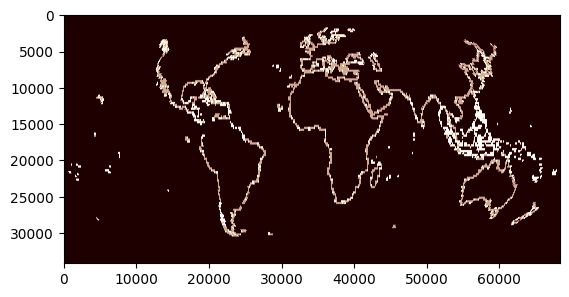

In [143]:
pyplot.imshow(array, cmap='pink')
pyplot.show()  

In [144]:
if array.max() == 1:
    cn = ["major"]
elif 1 in np.unique(array):
    cn = ["major","minor"]
else:
    cn = ["minor"]

In [145]:
np.unique(array)

array([0, 1, 2], dtype=uint8)

In [146]:
tsrs = raster.crs.to_proj4()

In [147]:
selection_xy=selection.to_crs(tsrs).reset_index()

In [148]:
selection_xy['area']=selection_xy.area

In [149]:
selection_xy

,index,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,...,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry,area
0,0,8444,United States Exclusive Economic Zone (America...,8670.0,200NM,2204,American Samoa,ASM,United States,NaN,...,None,None,840,NaN,NaN,16.0,NaN,NaN,"MULTIPOLYGON (((-15372413.687 -2292290.494, -1...",4.082725e+11
1,1,8379,British Exclusive Economic Zone (Ascension),8620.0,200NM,2208,Ascension,SHN,United Kingdom,NaN,...,None,None,826,NaN,NaN,654.0,NaN,NaN,"MULTIPOLYGON (((-1023920.591 -1037752.710, -10...",4.488914e+11
2,2,8446,New Zealand Exclusive Economic Zone (Cook Isla...,8672.0,200NM,2227,Cook Islands,COK,New Zealand,NaN,...,None,None,554,NaN,NaN,184.0,NaN,NaN,"MULTIPOLYGON (((-14942415.481 -763840.854, -14...",1.981976e+12
3,4,8440,French Exclusive Economic Zone (French Polynesia),8656.0,200NM,17,French Polynesia,PYF,France,NaN,...,None,None,250,NaN,NaN,258.0,NaN,NaN,"MULTIPOLYGON (((-12729785.943 -1039148.261, -1...",4.791009e+12
4,5,8439,British Exclusive Economic Zone (Pitcairn),2259.0,200NM,2208,Pitcairn,PCN,United Kingdom,NaN,...,None,None,826,NaN,NaN,612.0,NaN,NaN,"MULTIPOLYGON (((-12005668.331 -3428094.713, -1...",8.458191e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,274,62589,Mauritian Exclusive Economic Zone (Chagos Arch...,8616.0,200NM,8614,Chagos Archipelago,None,Republic of Mauritius,NaN,...,None,None,480,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6596834.461 -301628.408, 65968...",6.519179e+11
225,276,8402,British Exclusive Economic Zone (Bermuda),8636.0,200NM,2208,Bermuda,BMU,United Kingdom,NaN,...,None,None,826,NaN,NaN,60.0,NaN,NaN,"MULTIPOLYGON (((-5343378.309 4131298.266, -534...",4.657273e+11
226,277,8456,United States Exclusive Economic Zone,2204.0,200NM,2204,United States,USA,United States,NaN,...,None,None,840,NaN,NaN,840.0,NaN,NaN,"MULTIPOLYGON (((-5541125.633 5576013.984, -554...",2.456848e+12
227,278,8355,Sudanese Exclusive Economic Zone,2183.0,200NM,2183,Sudan,SDN,Sudan,NaN,...,None,None,729,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((3365328.050 2856452.561, 33653...",6.315248e+10


In [150]:
zs = zonal_stats(vectors=selection_xy.loc[:, 'geometry'], raster=rst, categorical=True)

In [151]:
stats = pd.DataFrame(zs).fillna(0) * cellarea#One column per raster category, and pixel count as value
stats.columns = cn

In [152]:
results = pd.concat([selection_xy.loc[:,('GEONAME','SOVEREIGN1','area')], stats], axis = 1)
results["EFG"] = thisefg[0]
results 

,GEONAME,SOVEREIGN1,area,major,minor,EFG
0,United States Exclusive Economic Zone (America...,United States,4.082725e+11,1.501859e+10,0.000000e+00,MT1.3
1,British Exclusive Economic Zone (Ascension),United Kingdom,4.488914e+11,0.000000e+00,0.000000e+00,MT1.3
2,New Zealand Exclusive Economic Zone (Cook Isla...,New Zealand,1.981976e+12,0.000000e+00,0.000000e+00,MT1.3
3,French Exclusive Economic Zone (French Polynesia),France,4.791009e+12,1.055869e+11,0.000000e+00,MT1.3
4,British Exclusive Economic Zone (Pitcairn),United Kingdom,8.458191e+11,0.000000e+00,0.000000e+00,MT1.3
...,...,...,...,...,...,...
224,Mauritian Exclusive Economic Zone (Chagos Arch...,Republic of Mauritius,6.519179e+11,1.221925e+10,0.000000e+00,MT1.3
225,British Exclusive Economic Zone (Bermuda),United Kingdom,4.657273e+11,0.000000e+00,0.000000e+00,MT1.3
226,United States Exclusive Economic Zone,United States,2.456848e+12,2.100422e+11,3.552757e+11,MT1.3
227,Sudanese Exclusive Economic Zone,Sudan,6.315248e+10,6.227572e+08,3.970819e+10,MT1.3


In [153]:
raster.close()

In [154]:
finalresults = results
pd.concat([results,finalresults], axis = 0)

,GEONAME,SOVEREIGN1,area,major,minor,EFG
0,United States Exclusive Economic Zone (America...,United States,4.082725e+11,1.501859e+10,0.000000e+00,MT1.3
1,British Exclusive Economic Zone (Ascension),United Kingdom,4.488914e+11,0.000000e+00,0.000000e+00,MT1.3
2,New Zealand Exclusive Economic Zone (Cook Isla...,New Zealand,1.981976e+12,0.000000e+00,0.000000e+00,MT1.3
3,French Exclusive Economic Zone (French Polynesia),France,4.791009e+12,1.055869e+11,0.000000e+00,MT1.3
4,British Exclusive Economic Zone (Pitcairn),United Kingdom,8.458191e+11,0.000000e+00,0.000000e+00,MT1.3
...,...,...,...,...,...,...
224,Mauritian Exclusive Economic Zone (Chagos Arch...,Republic of Mauritius,6.519179e+11,1.221925e+10,0.000000e+00,MT1.3
225,British Exclusive Economic Zone (Bermuda),United Kingdom,4.657273e+11,0.000000e+00,0.000000e+00,MT1.3
226,United States Exclusive Economic Zone,United States,2.456848e+12,2.100422e+11,3.552757e+11,MT1.3
227,Sudanese Exclusive Economic Zone,Sudan,6.315248e+10,6.227572e+08,3.970819e+10,MT1.3


Now all maps

In [24]:
targetdir = getimdir / 'output-rasters/geotiff-eck4/'
files = [f for f in targetdir.iterdir() if f.match("M*.tif")]
for file in files[1:5]:
    thisfile = os.path.basename(file)
    thisefg = re.findall(r'[MFTS]+[0-9]\.[0-9]+', thisfile)
    rst = getimdir / 'output-rasters/geotiff-eck4' / thisfile
    with rasterio.open(rst) as raster:
        cellarea = np.prod(raster.res)
        array = raster.read(1)
        if array.max() == 1:
            cn = ["major"]
        elif 1 in np.unique(array):
            cn = ["major","minor"]
        else:
            cn = ["minor"]
        tsrs = raster.crs.to_proj4()
        selection_xy=selection.to_crs(tsrs).reset_index()
        selection_xy['area']=selection_xy.area
    zs = zonal_stats(vectors=selection_xy.loc[:, 'geometry'], raster=rst, categorical=True)
    stats = pd.DataFrame(zs).fillna(0) * cellarea#One column per raster category, and pixel count as value
    stats.columns = cn
    results = pd.concat([selection_xy.loc[:,('GEONAME','SOVEREIGN1','area')], stats], axis = 1)
    results["EFG"] = thisefg[0]
    finalresults = pd.concat([results,finalresults], axis = 0)

KeyboardInterrupt: 

In [ ]:
finalresults = finalresults.fillna(0)

In [127]:
files = [f for f in targetdir.iterdir() if f.match("*.tif")]
files

[PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/T7.3.IM.alt_v2.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/MT1.3.IM.grid_v1.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/T3.1.IM.orig_v2.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/T7.5.WM.nwx_v1.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/T2.5.IM.alt_v2.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/F3.4.IM.orig_v1.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/SF1.1.IM.orig_v1.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/F3.3.IM.alt_v2.0.tif'),
 PosixPath('/home/jferrer/workdir/tmp/GET-IM-xport-zenodo/output-rasters/geotiff-eck4/FM1.3.IM.orig_v2.0.tif'),
 P

In [ ]:
finalresults[finalresults['SOVEREIGN1']=="Venezuela"]

In [ ]:
finalresults['p.major'] = finalresults['major']*100/finalresults['area']
finalresults['p.both'] = (finalresults['major']+finalresults['minor'])*100/finalresults['area']
countryresults = pd.pivot_table(finalresults, index='Sovereign1',columns='EFG',values='p.both',aggfunc="sum")

In [ ]:
with pd.ExcelWriter(repodir / 'data' / 'EFG-EZZ.xlsx') as writer:  
    finalresults.to_excel(writer, sheet_name='crosstab_EFG_by_EEZ')
    countryresults.to_excel(writer, sheet_name='EFG_by_countries')

### LME/admin combination
This is the combined layer prepared for the website

In [3]:
file = zipfile.ZipFile(gisdata / 'admin/global/LME-admin/lme_admin_20210519.zip')
file.extractall(path= tmpdir)

In [4]:
countries = gpd.read_file(tmpdir / 'lme_admin.shp' )

In [5]:
selection = countries.loc[308:309]
selection = countries.loc[countries['regiontype']=="ADM"]

selection.reset_index()

,index,region_id,regiontype,ignore,title_en,geometry
0,0,ADM_46,ADM,0,Russian Federation,"MULTIPOLYGON (((129.33406 72.77370, 129.20704 ..."
1,1,ADM_1,ADM,0,Indonesia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
2,2,ADM_2,ADM,0,Malaysia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
3,3,ADM_3,ADM,0,Chile,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
4,4,ADM_4,ADM,0,Bolivia,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
...,...,...,...,...,...,...
245,307,ADM_8,ADM,0,India,"MULTIPOLYGON (((79.12223 33.22890, 79.15365 33..."
246,309,ADM_9,ADM,0,China,"MULTIPOLYGON (((114.22983 22.55581, 114.23471 ..."
247,310,ADM_14,ADM,0,South Sudan,"POLYGON ((34.28011 4.52006, 34.17913 4.41991, ..."
248,311,ADM_84,ADM,0,Sudan,"MULTIPOLYGON (((37.26450 20.74999, 37.25441 20..."


In [6]:
rst = getimdir / 'output-rasters/geotiff-eck4/T7.4.WM.nwx_v1.0.tif'
raster = rasterio.open(rst)
cellarea = np.prod(raster.res)

In [7]:
tsrs = raster.crs.to_proj4()

In [8]:
selection_xy=selection.to_crs(tsrs).reset_index()

In [9]:
selection_xy['area']=selection_xy.area

In [10]:
selection_xy

,index,region_id,regiontype,ignore,title_en,geometry,area
0,0,ADM_46,ADM,0,Russian Federation,"MULTIPOLYGON (((8230552.663 7913051.363, 82237...",1.083403e+13
1,1,ADM_1,ADM,0,Indonesia,"MULTIPOLYGON (((11053285.830 548533.725, 11053...",1.892369e+12
2,2,ADM_2,ADM,0,Malaysia,"MULTIPOLYGON (((11053285.830 548533.725, 11052...",3.300722e+11
3,3,ADM_3,ADM,0,Chile,"MULTIPOLYGON (((-6412886.501 -2286055.147, -64...",7.380158e+11
4,4,ADM_4,ADM,0,Bolivia,"POLYGON ((-6412886.501 -2286055.147, -6412902....",1.092895e+12
...,...,...,...,...,...,...,...
245,307,ADM_8,ADM,0,India,"MULTIPOLYGON (((6939689.470 4230600.629, 69425...",3.198124e+12
246,309,ADM_9,ADM,0,China,"MULTIPOLYGON (((10406857.536 2926853.028, 1040...",9.502562e+12
247,310,ADM_14,ADM,0,South Sudan,"POLYGON ((3218563.624 595465.866, 3209257.581 ...",6.452892e+11
248,311,ADM_84,ADM,0,Sudan,"MULTIPOLYGON (((3411587.168 2699132.542, 34106...",1.868197e+12


In [11]:
zs = zonal_stats(vectors=selection_xy.loc[:, 'geometry'], raster=rst, categorical=True)


In [12]:
zs

[{1: 3620432, 2: 3527249},
 {1: 1982123, 2: 1417135},
 {1: 385615, 2: 287692},
 {1: 343336, 2: 349586},
 {1: 122226, 2: 210563},
 {1: 331696, 2: 478148},
 {1: 520455, 2: 770225},
 {1: 42507, 2: 14475},
 {1: 59654, 2: 16228},
 {1: 35455, 2: 5783},
 {1: 55468, 2: 8299},
 {1: 1027644, 2: 866187},
 {1: 28284, 2: 48089},
 {1: 494961, 2: 261498},
 {1: 1443564, 2: 733897},
 {1: 183845, 2: 166446},
 {1: 365766, 2: 418239},
 {1: 271482, 2: 166919},
 {1: 1972136, 2: 1654478},
 {1: 15594, 2: 15718},
 {1: 18803, 2: 25681},
 {1: 595570, 2: 127722},
 {1: 74628, 2: 120940},
 {1: 401054, 2: 350838},
 {1: 77128, 2: 68947},
 {1: 55370, 2: 81579},
 {1: 18237, 2: 26642},
 {1: 222097, 2: 448029},
 {1: 18540, 2: 24801},
 {1: 1412223, 2: 966333},
 {1: 327602, 2: 359744},
 {1: 37528, 2: 53452},
 {1: 847964, 2: 641295},
 {1: 552, 2: 32},
 {1: 203},
 {1: 99158, 2: 73068},
 {1: 492184, 2: 173670},
 {1: 436309, 2: 420680},
 {1: 130114, 2: 66574},
 {1: 99792, 2: 139044},
 {1: 1987655, 2: 3008648},
 {1: 47147, 2: 6

In [13]:
stats = pd.DataFrame(zs).fillna(0) * cellarea#One column per raster category, and pixel count as value
stats.columns = ['major','minor']

NameError: name 'results' is not defined

In [14]:
results = pd.concat([selection_xy.loc[:,('region_id','title_en','area')], stats], axis = 1)
results 

,region_id,title_en,area,major,minor
0,ADM_46,Russian Federation,1.083403e+13,4.229994e+11,4.121122e+11
1,ADM_1,Indonesia,1.892369e+12,2.315848e+11,1.655734e+11
2,ADM_2,Malaysia,3.300722e+11,4.505399e+10,3.361299e+10
3,ADM_3,Chile,7.380158e+11,4.011425e+10,4.084448e+10
4,ADM_4,Bolivia,1.092895e+12,1.428049e+10,2.460149e+10
...,...,...,...,...,...
245,ADM_8,India,3.198124e+12,1.084822e+12,7.794789e+11
246,ADM_9,China,9.502562e+12,2.375971e+12,1.044031e+12
247,ADM_14,South Sudan,6.452892e+11,1.635130e+09,2.332645e+09
248,ADM_84,Sudan,1.868197e+12,2.293622e+10,2.149422e+10


In [15]:
results['p_major'] =  results['major']/results['area']#From area to percentage
results['p_minor'] =  results['minor']/results['area']#From area to percentage


In [16]:
results

,region_id,title_en,area,major,minor,p_major,p_minor
0,ADM_46,Russian Federation,1.083403e+13,4.229994e+11,4.121122e+11,0.039044,0.038039
1,ADM_1,Indonesia,1.892369e+12,2.315848e+11,1.655734e+11,0.122378,0.087495
2,ADM_2,Malaysia,3.300722e+11,4.505399e+10,3.361299e+10,0.136497,0.101835
3,ADM_3,Chile,7.380158e+11,4.011425e+10,4.084448e+10,0.054354,0.055344
4,ADM_4,Bolivia,1.092895e+12,1.428049e+10,2.460149e+10,0.013067,0.022510
...,...,...,...,...,...,...,...
245,ADM_8,India,3.198124e+12,1.084822e+12,7.794789e+11,0.339206,0.243730
246,ADM_9,China,9.502562e+12,2.375971e+12,1.044031e+12,0.250035,0.109868
247,ADM_14,South Sudan,6.452892e+11,1.635130e+09,2.332645e+09,0.002534,0.003615
248,ADM_84,Sudan,1.868197e+12,2.293622e+10,2.149422e+10,0.012277,0.011505


In [35]:
results.sort_values(by=("major"), ascending=False)

,region_id,title_en,area,major,minor,p_major,p_minor,area_km2
246,ADM_9,China,9.502562e+12,2.375971e+12,1.044031e+12,0.250035,0.109868,9.502562e+06
145,ADM_150,United States of America,9.469103e+12,1.342726e+12,1.260170e+12,0.141801,0.133082,9.469103e+06
245,ADM_8,India,3.198124e+12,1.084822e+12,7.794789e+11,0.339206,0.243730,3.198124e+06
0,ADM_46,Russian Federation,1.083403e+13,4.229994e+11,4.121122e+11,0.039044,0.038039,1.083403e+07
40,ADM_43,Brazil,8.523995e+12,2.322311e+11,3.515206e+11,0.027244,0.041239,8.523995e+06
...,...,...,...,...,...,...,...,...
232,ADM_239,Cocos (Keeling) Islands (Aus.),1.328940e+07,0.000000e+00,0.000000e+00,0.000000,0.000000,1.328940e+01
174,ADM_180,French Southern and Antarctic Lands (Fr.),7.273220e+09,0.000000e+00,3.855612e+06,0.000000,0.000530,7.273220e+03
227,ADM_233,Clipperton Island (Fr.),5.033492e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,5.033492e+00
208,ADM_214,Norfolk Island (Aus.),4.129335e+07,0.000000e+00,0.000000e+00,0.000000,0.000000,4.129335e+01


In [27]:
# compare with 148,940,000 for land areas of the earth according to https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area
results['area_km2'] = results['area']/1e6
results['area_km2'].sum() 

130132982.79441328

In [33]:
results.loc[0:3,['title_en','area_km2','major','minor']]

,title_en,area_km2,major,minor
0,Russian Federation,1.083403e+07,4.229994e+11,4.121122e+11
1,Indonesia,1.892369e+06,2.315848e+11,1.655734e+11
2,Malaysia,3.300722e+05,4.505399e+10,3.361299e+10
3,Chile,7.380158e+05,4.011425e+10,4.084448e+10


In [29]:
results['major'].sum() *100 / results['area'].sum()

8.388702627084964

In [30]:
results['minor'].sum() *100 / results['area'].sum()

6.5207433582075485

In [32]:
results['major'].sum() / 1e6

10916468.94637897